# Embedding Models and Semantic Reasoning

In [ ]:
%pip install -qq langchain langchain-nvidia-ai-endpoints gradio
%pip install -qq arxiv pymupdf
%pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import os
os.environ["NVIDIA_API_KEY"] = "NVIDIA_API_KEY"

### Word embeddings are high-dimensional vector representations of individual words, forming the backbone of deep language models. These embeddings are created through an optimization process within an end-to-end pipeline tailored for specific tasks. Word2vec is a prominent standalone example for those interested. In practical terms, a token from a language model's token vocabulary gets mapped from a token index to an dimensional token embedding

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

In [ ]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]

In [ ]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: user 78.5 ms, sys: 5.9 ms, total: 84.5 ms
Wall time: 2.94 s


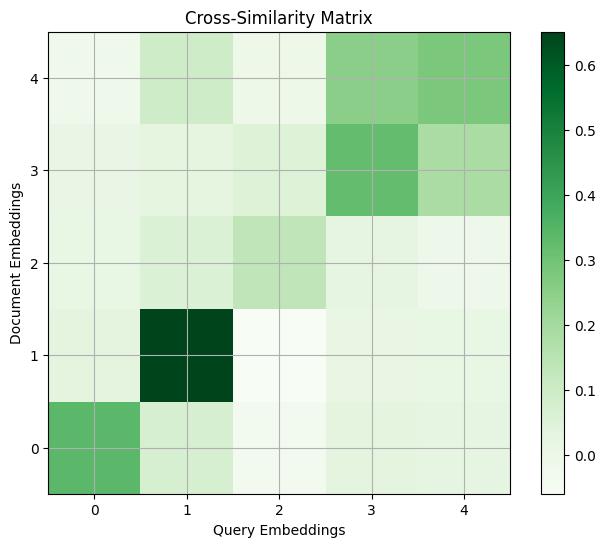

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):

    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings)
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

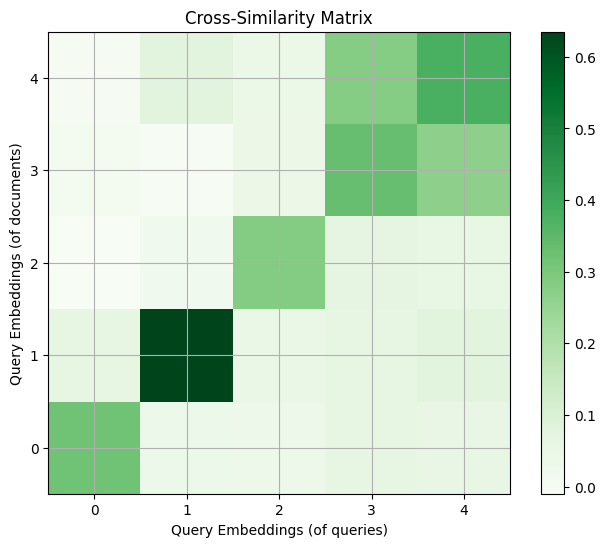

In [ ]:
plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(
    q_embeddings,
    [embedder.embed_query(doc) for doc in documents]
)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of documents)")
plt.show()

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

expound_prompt = ChatPromptTemplate.from_template(
    "Generate part of a longer story that could reasonably answer all"
    " of these questions somewhere in its contents: {questions}\n"
    " Make sure the passage only answers the following concretely: {q1}."
    " Give it some weird formatting, and try not to answer the others."
    " Do not include any commentary like 'Here is your response'"
)

In [ ]:
from pprint import pprint

expound_chain = {}

longer_docs = []
for i, q in enumerate(queries):
    # The longer_doc was initially an empty string ""

    longer_doc = f"Longer document related to query {i+1}: {q}"
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-" * 64)
    longer_docs += [longer_doc]

'\n\n[Query 1]'
What's the weather like in Rocky Mountains?
'\n\n[Document 1]'
Longer document related to query 1: What's the weather like in Rocky Mountains?
'----------------------------------------------------------------'
'\n\n[Query 2]'
What kinds of food is Italy known for?
'\n\n[Document 2]'
Longer document related to query 2: What kinds of food is Italy known for?
'----------------------------------------------------------------'
'\n\n[Query 3]'
What's my name? I bet you don't remember...
'\n\n[Document 3]'
Longer document related to query 3: What's my name? I bet you don't remember...
'----------------------------------------------------------------'
'\n\n[Query 4]'
What's the point of life anyways?
'\n\n[Document 4]'
Longer document related to query 4: What's the point of life anyways?
'----------------------------------------------------------------'
'\n\n[Query 5]'
The point of life is to have fun :D
'\n\n[Document 5]'
Longer document related to query 5: The point of life i

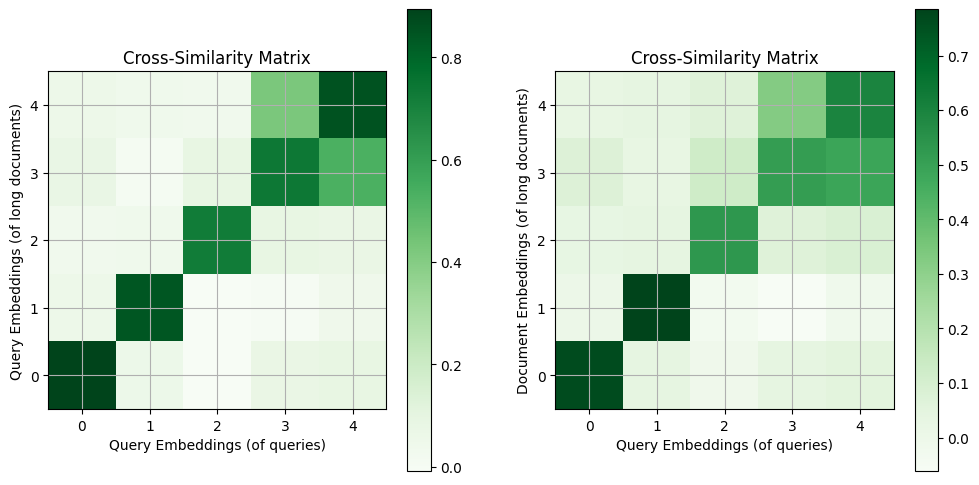

In [ ]:
## At the time of writing, our embedding model supports up to 2048 tokens...
longer_docs_cut = [doc[:2048] for doc in longer_docs]

q_long_embs = [embedder._embed([doc], model_type='query')[0] for doc in longer_docs_cut]
d_long_embs = [embedder._embed([doc], model_type='passage')[0] for doc in longer_docs_cut]

## We've raised the similarity matrix to the power of 5 to try and spot a difference.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_cross_similarity_matrix(q_embeddings, q_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of long documents)")

plt.subplot(1, 2, 2)
plot_cross_similarity_matrix(q_embeddings, d_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Document Embeddings (of long documents)")
plt.show()